In [6]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import soundfile
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import build
from dct import isdct, sdct
from models import *
from train import generate

In [2]:
class DaNet(pl.LightningModule):
    def __init__(self, model_loader, noise=0.0):
        super().__init__()
        self.save_hyperparameters()
        self.model = eval(model_loader)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, aux = batch
        x += torch.randn_like(x) * self.noise
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

In [3]:
model = DaNet.load_from_checkpoint('lightning_logs/version_7/checkpoints/epoch=0-step=10.ckpt')

In [40]:
trainer = pl.Trainer(progress_bar_refresh_rate=0)

c:\Users\msh24\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\msh24\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
def helper(data):
    return trainer.predict(model, DataLoader([data[0]], batch_size=1))[0]

In [41]:
x = generate(model, 1000, show_progress=True)

100%|██████████| 1000/1000 [00:05<00:00, 184.35it/s]


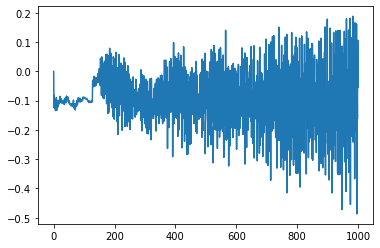

In [29]:
plt.plot(x[0])
plt.show()